# EDA

In [71]:
# Import helpful libraries
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
import math

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler

# modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

In [72]:
# Load the data, and separate the target
iowa_file_path = r'.\data\train.csv'
home_data = pd.read_csv(iowa_file_path)

In [73]:
# path to file you will use for predictions
test_data_path = r'.\data\test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# Results default Kaggle model

First 15 predictions:

[122657.0,
 156789.0,
 182959.0,
 178102.0,
 189049.0,
 180979.0,
 172797.0,
 173717.0,
 187535.0,
 116172.0,
 190798.0,
 93823.0,
 89249.0,
 145111.0,
 124696.0]
 
Validation MAE for DEFAULT Random Forest Model: **21,857**

# Model optimization

· Will clean the dataset, hot-code categorical features, scale numerical features, and train a new model

## Defining functions

In [74]:
def drop_columns_nan(dataframe, threshold: int) -> pd.DataFrame:
  """Drops columns from a DataFrame that contain a certain amount of missing values (NaNs).

  Args:
      dataframe: The pandas DataFrame to process.
      threshold: The minimum number of NaNs a column must have to be dropped.
          A column will be dropped if the number of NaNs is greater than or equal to this threshold.

  Returns:
      The modified DataFrame with columns containing a high number of NaNs dropped.
  """
  columns_to_drop = [col for col in dataframe.columns if dataframe[col].isnull().sum() >= threshold]
  dataframe.drop(columns_to_drop, axis=1, inplace=True)
  print(f'Dropped {len(columns_to_drop)} columns -{columns_to_drop}- with NaNs >= {threshold}')

####################################################################################################

def drop_notinformative(df, threshold=0.95):
    """  drop columns with high percentage of ONE UNIQUE value
    """
    
    columns_to_drop = []
    threshold = 0.9
    for col in df.columns:
        value_counts = df[col].value_counts(normalize=True)
        if len(value_counts) == 1 or value_counts.iloc[0] > threshold:  # Check for single value or exceeding threshold
            columns_to_drop.append(col)

    df.drop(columns_to_drop, axis=1, inplace=True)
    print(f'dropped columns: {columns_to_drop}')
  

#################################################################################################

def impute_nan_custom(df, method_numerical='mean', value_categorical='Non-existent', fill_categorical_with_mode=False):
  """
  Imputes missing values in a DataFrame with user-defined options

  Args:
      df (pandas.DataFrame): The DataFrame to impute
      method_numerical (str, optional): Method to impute numerical columns. Defaults to 'mean'. Valid options are 'mean', 'median', 'zero', or 'mode'.
      value_categorical (str, optional): Value to use for imputing missing values in categorical columns. Defaults to 'Non-existent'.
      fill_categorical_with_mode (bool, optional): If True, fills missing values in categorical columns with the mode. Defaults to False.

  Returns:
      pandas.DataFrame: The DataFrame with imputed missing values
      list: A list of columns containing missing values

  Raises:
      ValueError: If an invalid method_numerical is provided.
  """
  columns_with_nan = []
  for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].dtype.kind in ['f', 'i']:  # Check for float or integer
      if method_numerical == 'mean':
        df[col] = df[col].fillna(value=df[col].mean())
      elif method_numerical == 'median':
        df[col] = df[col].fillna(value=df[col].median())
      elif method_numerical == 'zero':
        df[col] = df[col].fillna(value=0)
      elif method_numerical == 'mode':
        df[col] = df[col].fillna(value=df[col].mode()[0])
      else:
        raise ValueError(f"Invalid method_numerical: {method_numerical}. Valid options are 'mean', 'median', 'zero', or 'mode'.")
      columns_with_nan.append(col)
    elif df[col].isnull().sum() > 0 and fill_categorical_with_mode and pd.api.types.is_categorical_dtype(df[col]):
      df[col] = df[col].fillna(value=df[col].mode()[0])  # Fill with mode for categorical
      columns_with_nan.append(col)
    elif df[col].isnull().sum() > 0:
      df[col] = df[col].fillna(value=value_categorical)
      columns_with_nan.append(col)
  return columns_with_nan

#################################################################################################

def replace_less_frequent(df: pd.DataFrame, list_col: list[str], threshold: float = 0.02, new_value='other') -> pd.DataFrame:
  """Replaces less frequent values in specified columns of a DataFrame with a new value.

  This function identifies values that appear less frequently than a certain threshold
  within specified columns of a DataFrame and replaces them with a new user-defined value.
  It also prints value counts to confirm the changes.

  Args:
      df: The pandas DataFrame to process.
      list_col: A list of column names to be processed.
      threshold: The minimum frequency (between 0 and 1) a value must have to be considered
          frequent. Values with frequency less than the threshold will be replaced.
      new_value: The value to use for replacing less frequent values.

  Returns:
      The modified DataFrame with less frequent values replaced.

  Prints:
      Value counts for each modified column after the replacement.
  """

  vals_to_change = []

  # Iterate over each column in the list
  for col in list_col:
    # Get values with frequency less than the threshold
    filtered_values = df[col].value_counts(normalize=True)
    filtered_values = filtered_values[filtered_values < threshold].index.tolist()
    vals_to_change.extend(filtered_values)  # Extend to avoid nested lists

  # Replace less frequent values with new_value
  for col in list_col:
    df[col] = np.where(df[col].isin(vals_to_change), new_value, df[col])

  # Print value counts for each modified column
  for col in list_col:
    print(f"\nValue Counts for {col} after replacement:")
    print(df[col].value_counts(normalize=True, dropna=False))
    print(f"\n** NEW {col} created correctly**")


#######################################################################################################

def get_categorical(df):
  """
  Identifies categorical columns in a DataFrame

  Args:
      df (pandas.DataFrame): The DataFrame to identify categorical columns in

  Returns:
      list: A list containing the names of categorical columns
  """
  return df.select_dtypes(include=['object', 'category']).columns.tolist()

#######################################################################################################

def get_numeric(df):
  """
  Identifies categorical columns in a DataFrame

  Args:
      df (pandas.DataFrame): The DataFrame to identify categorical columns in

  Returns:
      list: A list containing the names of categorical columns
  """
  l_num = []
  for col in df.columns:
    if df[col].dtype.kind == 'f' or df[col].dtype.kind == 'i':  # Check for object dtype (categorical)
      l_num.append(col)
  return l_num

#######################################################################################################

def get_posible_bool(df):
  """
  Identifies categorical columns in a DataFrame

  Args:
      df (pandas.DataFrame): The DataFrame to identify categorical columns in

  Returns:
      list: A list containing the names of categorical columns
  """
  l_bool = []
  for col in df.columns:
    if len(df[col].unique()) == 2:  # Check for object dtype (categorical)
      l_bool.append(col)
  return l_bool

## Cleaning dataset

In [75]:
import pandas as pd
import numpy as np

In [76]:
pd.set_option('display.max_rows', None)

# Drop columns that are not in test data

In [77]:
columns_to_keep = test_data.columns.tolist()

In [78]:
len(columns_to_keep)

80

In [79]:
for col in home_data.columns:
    if col != 'SalePrice' and col not in columns_to_keep:
        home_data.drop(col, axis=1, inplace=True)

# Now drop in test columns that are not in home data

In [80]:
columns_to_keep = home_data.columns.tolist()
for col in test_data.columns:
    if col != 'SalePrice' and col not in columns_to_keep:
        test_data.drop(col, axis=1, inplace=True)

In [81]:
datasets = [home_data, test_data]
for table in datasets:
    table.set_index('Id', inplace=True)

In [82]:
home_data2 = home_data.copy()

In [83]:
datasets = [home_data2, test_data]

In [84]:
for table in datasets:
    table['MasVnrArea'] = table['MasVnrArea'].fillna(0)
    table['GarageYrBlt'] = table['GarageYrBlt'].fillna(table['YearBuilt'])
    table['LotFrontage'] = table['LotFrontage'].fillna(table['LotFrontage'].mean())

In [85]:
for table in datasets:
    categorical_columns = get_categorical(table)
    table[categorical_columns] = table[categorical_columns].fillna('absent')

In [86]:
# if GarageType = NaN, no garage
# drop BsmtExposure and BsmtFinType2 cause they dont match other basements

for table in datasets:
    del(table['BsmtExposure'])
    del(table['BsmtFinType2'])

In [87]:
#ordinal encoding --> I do this now before I replace low frequent values only for COLUMNS TO BE RANKED

columns_to_encode = ['LotShape', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual']

categories = [
    ['Reg', 'IR1', 'IR2', 'IR3'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    ['Fin', 'RFn', 'Unf', 'NA'],
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
]

# Replace 'NA' with 'absent' and then reverse each sublist
reversed_categories = []

for lst in categories:
    reversed_lst = ['absent' if x == 'NA' else x for x in lst]
    reversed_categories.append(reversed_lst[::-1])

# Initialize the OrdinalEncoder with the defined categories
encoder = OrdinalEncoder(categories=reversed_categories, handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder on the training data
encoder.fit(home_data2[columns_to_encode])

# Transform both the training and testing data
home_data2_encoded = encoder.transform(home_data2[columns_to_encode])
test_data_encoded = encoder.transform(test_data[columns_to_encode])

# Assigning encoded values to the original dataframe
for i, col in enumerate(columns_to_encode):
    home_data2[col + '_Encoded'] = home_data2_encoded[:, i]
    test_data[col + '_Encoded'] = test_data_encoded[:, i]

# Some Nan remain in test data

In [88]:
impute_nan_custom(test_data, method_numerical='zero', fill_categorical_with_mode=True)

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea']

# drop not informative and group low frequent categories into 'other' category

In [89]:
#remove low informative
drop_notinformative(home_data2, threshold=0.95)

dropped columns: ['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageCond', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal']


In [90]:
dropped_columns = ['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageCond', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal']
test_data.drop(dropped_columns, axis=1, inplace=True)

In [91]:
def replace_less_frequent(df: pd.DataFrame, list_col: list[str], threshold: float = 0.02, new_value='other') -> tuple[pd.DataFrame, dict[str, list]]:
    """Replaces less frequent values in specified columns of a DataFrame with a new value and returns the DataFrame and a dictionary of less frequent values.

    Args:
        df: The pandas DataFrame to process.
        list_col: A list of column names to be processed.
        threshold: The minimum frequency (between 0 and 1) a value must have to be considered
            frequent. Values with frequency less than the threshold will be replaced.
        new_value: The value to use for replacing less frequent values.

    Returns:
        A tuple containing:
        - The modified DataFrame with less frequent values replaced.
        - A dictionary where keys are column names and values are lists of less frequent values.
    """
    less_frequent_values = {}

    # Iterate over each column in the list
    for col in list_col:
        # Get values with frequency less than the threshold
        filtered_values = df[col].value_counts(normalize=True)
        less_frequent = filtered_values[filtered_values < threshold].index.tolist()
        less_frequent_values[col] = less_frequent

    # Replace less frequent values with new_value
    for col in list_col:
        df[col] = np.where(df[col].isin(less_frequent_values[col]), new_value, df[col])

    return df, less_frequent_values


In [92]:
home_data3 = home_data2.copy()

In [93]:
home_data3, less_frequent_values = replace_less_frequent(home_data3, get_categorical(home_data3), threshold=0.02, new_value='other')

In [94]:
less_frequent_values

{'MSZoning': ['RH', 'C (all)'],
 'LotShape': ['IR3'],
 'LandContour': [],
 'LotConfig': ['FR3'],
 'Neighborhood': ['ClearCr',
  'StoneBr',
  'SWISU',
  'MeadowV',
  'Blmngtn',
  'BrDale',
  'Veenker',
  'NPkVill',
  'Blueste'],
 'Condition1': ['RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe'],
 'BldgType': [],
 'HouseStyle': ['1.5Unf', '2.5Unf', '2.5Fin'],
 'RoofStyle': ['Flat', 'Gambrel', 'Mansard', 'Shed'],
 'Exterior1st': ['WdShing',
  'Stucco',
  'AsbShng',
  'BrkComm',
  'Stone',
  'AsphShn',
  'ImStucc',
  'CBlock'],
 'Exterior2nd': ['Stucco',
  'BrkFace',
  'AsbShng',
  'ImStucc',
  'Brk Cmn',
  'Stone',
  'AsphShn',
  'Other',
  'CBlock'],
 'MasVnrType': ['BrkCmn'],
 'ExterQual': ['Fa'],
 'ExterCond': ['Fa', 'Ex', 'Po'],
 'Foundation': ['Slab', 'Stone', 'Wood'],
 'BsmtQual': [],
 'BsmtCond': ['Po'],
 'BsmtFinType1': [],
 'HeatingQC': ['Po'],
 'KitchenQual': [],
 'FireplaceQu': ['Ex', 'Po'],
 'GarageType': ['Basment', 'CarPort', '2Types'],
 'GarageFinish': [],
 'GarageQual': ['Gd'

In [95]:
def replace_with_stored_values(df: pd.DataFrame, list_col: list[str], less_frequent_values: dict[str, list], new_value='other') -> pd.DataFrame:
    """Replaces values in specified columns of a DataFrame with a new value based on stored less frequent values.

    Args:
        df: The pandas DataFrame to process.
        list_col: A list of column names to be processed.
        less_frequent_values: A dictionary where keys are column names and values are lists of less frequent values.
        new_value: The value to use for replacing less frequent values.

    Returns:
        The modified DataFrame with less frequent values replaced.
    """
    for col in list_col:
        df[col] = np.where(df[col].isin(less_frequent_values[col]), new_value, df[col])
    
    return df

In [96]:
test_data2 = test_data.copy()

In [97]:
test_data2 = replace_with_stored_values(test_data2, get_categorical(test_data2), less_frequent_values, new_value='other')

In [98]:
home_data3.MSZoning.value_counts(normalize=True, dropna=False)

MSZoning
RL       0.788356
RM       0.149315
FV       0.044521
other    0.017808
Name: proportion, dtype: float64

In [99]:
test_data2.MSZoning.value_counts(normalize=True, dropna=False)

MSZoning
RL        0.763537
RM        0.165867
FV        0.050720
other     0.017135
absent    0.002742
Name: proportion, dtype: float64

In [100]:
#home_data3.to_csv("home_data3.csv")

#test_data2.to_csv("test_data2.csv")

# transform features

In [101]:
datasets = [home_data3, test_data2]

In [102]:
get_posible_bool(test_data2)

[]

In [103]:
for table in datasets:
    for col in table.columns:
        print(f'\n{col}: Unique values = {table[col].nunique()}')


MSSubClass: Unique values = 15

MSZoning: Unique values = 4

LotFrontage: Unique values = 111

LotArea: Unique values = 1073

LotShape: Unique values = 4

LandContour: Unique values = 4

LotConfig: Unique values = 5

Neighborhood: Unique values = 17

Condition1: Unique values = 4

BldgType: Unique values = 5

HouseStyle: Unique values = 6

OverallQual: Unique values = 10

OverallCond: Unique values = 9

YearBuilt: Unique values = 112

YearRemodAdd: Unique values = 61

RoofStyle: Unique values = 3

Exterior1st: Unique values = 8

Exterior2nd: Unique values = 8

MasVnrType: Unique values = 4

MasVnrArea: Unique values = 327

ExterQual: Unique values = 4

ExterCond: Unique values = 3

Foundation: Unique values = 4

BsmtQual: Unique values = 5

BsmtCond: Unique values = 5

BsmtFinType1: Unique values = 7

BsmtFinSF1: Unique values = 637

BsmtFinSF2: Unique values = 144

BsmtUnfSF: Unique values = 780

TotalBsmtSF: Unique values = 721

HeatingQC: Unique values = 5

1stFlrSF: Unique values 

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
"""%matplotlib inline 

for col in set(datasets[0].columns).intersection(datasets[1].columns):  
    if datasets[0][col].dtype in ['int64', 'float64']:  # Check if column is numerical
        # Create a temporary dataframe containing the current column from both datasets
        temp_df = pd.DataFrame({f'Home Data - {col}': datasets[0][col], 
                                f'Test Data - {col}': datasets[1][col]})
        plt.figure(figsize=(10, 5))
        sns.kdeplot(data=temp_df)
        plt.title(f'Overlapped Histogram for {col}')
        plt.show()"""

"%matplotlib inline \n\nfor col in set(datasets[0].columns).intersection(datasets[1].columns):  \n    if datasets[0][col].dtype in ['int64', 'float64']:  # Check if column is numerical\n        # Create a temporary dataframe containing the current column from both datasets\n        temp_df = pd.DataFrame({f'Home Data - {col}': datasets[0][col], \n                                f'Test Data - {col}': datasets[1][col]})\n        plt.figure(figsize=(10, 5))\n        sns.kdeplot(data=temp_df)\n        plt.title(f'Overlapped Histogram for {col}')\n        plt.show()"

In [106]:
# drop cols because there is one with total surface basement
cols = ["BsmtFinSF1", "BsmtFinSF2"]
for table in datasets:
    table.drop(columns=cols, axis=1, inplace=True)

In [107]:
for table in datasets:
    table['real_Basement_area'] = table['TotalBsmtSF'] - table['BsmtUnfSF']
    table['total_Flr_surface'] = table['1stFlrSF']	+ table['2ndFlrSF']

In [108]:
# month sold to sen and cos

for table in datasets:
    table['MoSold'] = table['MoSold'] * 2 * math.pi / 12

    table['MoSold_cos'] = table['MoSold'].apply(lambda x: math.cos(x))
    table['MoSold_sin'] = table['MoSold'].apply(lambda x: math.sin(x))

    table = table.drop('MoSold', axis=1)

In [109]:
# Convert years to ages in years and days

for table in datasets:
    table['YearBuilt_age'] = (table['YrSold'] - table['YearBuilt']) * 365
    table['last_remod_age'] = (table['YrSold'] - table['YearRemodAdd']) * 365
    table['GarageYrBlt_age'] = (table['YrSold'] - table['GarageYrBlt']) * 365

In [110]:
for table in datasets:
    table['MSSubClass'] = table['MSSubClass'].astype(str)

# Correlations

In [ ]:
"""# se grafica las correlaciones con un mapa de calor heatmap
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(home_data3.corr(numeric_only=True), cmap="YlGnBu")
plt.show()"""

# target encoding of all categorical features

In [113]:
from category_encoders import TargetEncoder

for col in ['MSSubClass', 'Neighborhood']:

    home_data3[col] = home_data3[col].astype('category')
    test_data2[col] = test_data2[col].astype('category')

    # primero hago fit_transform para conocer la media de la target del dataset de entrenamiento
    # despues hago el transform para cambiar el valor de la categoría del dataset a predecir por la media calculada en el dataset de entrenamiento
    codificador = TargetEncoder()
    home_data3[col] = codificador.fit_transform(home_data3[col], home_data3['SalePrice'])
    test_data2[col] = codificador.transform(test_data2[col])

## one-hot-encoding categorical features and scale numerical features

In [114]:
home_dummies = pd.get_dummies(home_data3)

test_dummies = pd.get_dummies(test_data2)

In [115]:
corr_matrix = home_dummies.corr()

# Transform the upper-right triangle to zeros
upper_triangle_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_matrix_upper_zero = corr_matrix.mask(upper_triangle_mask)

# Print the pairs of correlated variables
corr_result = corr_matrix_upper_zero.unstack().sort_values(ascending=False) # type: ignore
corr_result_df = corr_result.reset_index()
print(corr_result_df[(corr_result_df['level_0'] != corr_result_df['level_1'])].to_string())

                     level_0                level_1             0
90         GarageType_absent      GarageQual_absent  1.000000e+00
91         GarageType_absent    GarageFinish_absent  1.000000e+00
128      GarageFinish_absent      GarageQual_absent  1.000000e+00
162          BsmtCond_absent    BsmtFinType1_absent  1.000000e+00
167          BsmtQual_absent    BsmtFinType1_absent  1.000000e+00
168          BsmtQual_absent        BsmtCond_absent  1.000000e+00
176                GrLivArea      total_Flr_surface  9.957176e-01
177             SaleType_New  SaleCondition_Partial  9.868190e-01
178      Exterior1st_VinylSd    Exterior2nd_VinylSd  9.775249e-01
179      Exterior1st_CemntBd    Exterior2nd_CmentBd  9.741711e-01
180      Exterior1st_MetalSd    Exterior2nd_MetalSd  9.730652e-01
181         LotShape_Encoded           LotShape_Reg  9.221302e-01
182        HeatingQC_Encoded           HeatingQC_Ex  9.047109e-01
183      Exterior1st_HdBoard    Exterior2nd_HdBoard  8.832714e-01
184       

In [116]:
# Initialize an empty list to store the values
correlated_values = []

# Iterate through the DataFrame
for index, row in corr_result_df.iterrows():
    if row['level_0'] != row['level_1'] and ((row[0] > 0.95) or (row[0] < -0.95)):
        correlated_values.append(row['level_0'])  # or row['level_1'] depending on which value you want to store

# Print the list of correlated values
print(correlated_values)

['GarageType_absent', 'GarageType_absent', 'GarageFinish_absent', 'BsmtCond_absent', 'BsmtQual_absent', 'BsmtQual_absent', 'GrLivArea', 'SaleType_New', 'Exterior1st_VinylSd', 'Exterior1st_CemntBd', 'Exterior1st_MetalSd', 'FireplaceQu_Encoded', 'YearRemodAdd', 'GarageYrBlt', 'YearBuilt']


In [117]:
datasets = [home_dummies, test_dummies]
for table in datasets:
    table.drop(columns=correlated_values, axis=1, inplace=True)

## Train test split

In [118]:
common_columns = list(set(home_dummies.columns).intersection(test_dummies.columns))

In [119]:
# Split data into features (X) and target (y)
X = home_dummies[common_columns]  # Assuming common_columns excludes SalePrice
y = home_dummies.SalePrice
predict = test_dummies[common_columns]

# Split data into training and testing sets (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## competición de modelos

In [54]:
"""# añadimos en una lista los modelos que queremos poner a competir

modelos = []
#modelos.append(('LinearRegression', LinearRegression()))
#modelos.append(('Lasso', Lasso()))
#modelos.append(('Ridge', Ridge()))
#modelos.append(('ElasticNet', ElasticNet()))
#modelos.append(('SGDRegressor', SGDRegressor()))
#modelos.append(('SVC', SVC()))
modelos.append(('RandomForestRegressor', RandomForestRegressor()))
modelos.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
modelos.append(('XGBRegressor', XGBRegressor(objective ='reg:squarederror')))
modelos.append(('CatBoostRegressor', CatBoostRegressor(verbose=False)))"""

"# añadimos en una lista los modelos que queremos poner a competir\n\nmodelos = []\n#modelos.append(('LinearRegression', LinearRegression()))\n#modelos.append(('Lasso', Lasso()))\n#modelos.append(('Ridge', Ridge()))\n#modelos.append(('ElasticNet', ElasticNet()))\n#modelos.append(('SGDRegressor', SGDRegressor()))\n#modelos.append(('SVC', SVC()))\nmodelos.append(('RandomForestRegressor', RandomForestRegressor()))\nmodelos.append(('GradientBoostingRegressor', GradientBoostingRegressor()))\nmodelos.append(('XGBRegressor', XGBRegressor(objective ='reg:squarederror')))\nmodelos.append(('CatBoostRegressor', CatBoostRegressor(verbose=False)))"

In [55]:
"""# Create an empty DataFrame to store the metrics
metricas_modelos = pd.DataFrame(columns=['modelo', 'MAE'])

for nombre, modelo in modelos:

    # Train the model
    modelo.fit(X_train, y_train)

    # Make predictions on the test dataset
    y_pred = modelo.predict(X_test)

    # Calculate the Mean Absolute Error (MAE)
    mae = metrics.mean_absolute_error(y_test, y_pred)

    # Print the result for each model
    print(modelo, mae)

    # Append the results to the DataFrame
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'MAE': mae}, index=[0])
                                  ])

# Sort the DataFrame by MAE
metricas_modelos.sort_values('MAE')"""

"# Create an empty DataFrame to store the metrics\nmetricas_modelos = pd.DataFrame(columns=['modelo', 'MAE'])\n\nfor nombre, modelo in modelos:\n\n    # Train the model\n    modelo.fit(X_train, y_train)\n\n    # Make predictions on the test dataset\n    y_pred = modelo.predict(X_test)\n\n    # Calculate the Mean Absolute Error (MAE)\n    mae = metrics.mean_absolute_error(y_test, y_pred)\n\n    # Print the result for each model\n    print(modelo, mae)\n\n    # Append the results to the DataFrame\n    metricas_modelos = pd.concat([metricas_modelos,\n                                  pd.DataFrame({'modelo': nombre, 'MAE': mae}, index=[0])\n                                  ])\n\n# Sort the DataFrame by MAE\nmetricas_modelos.sort_values('MAE')"

# Feature importance for catboost model

In [120]:
# Define and train the initial model
catboost_model = CatBoostRegressor(silent=True)
catboost_model.fit(X_train, y_train)

# Get feature importances
feature_importances = catboost_model.get_feature_importance()
feature_names = [f'{i}' for i in X.columns]

# Create dataframe with feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [121]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

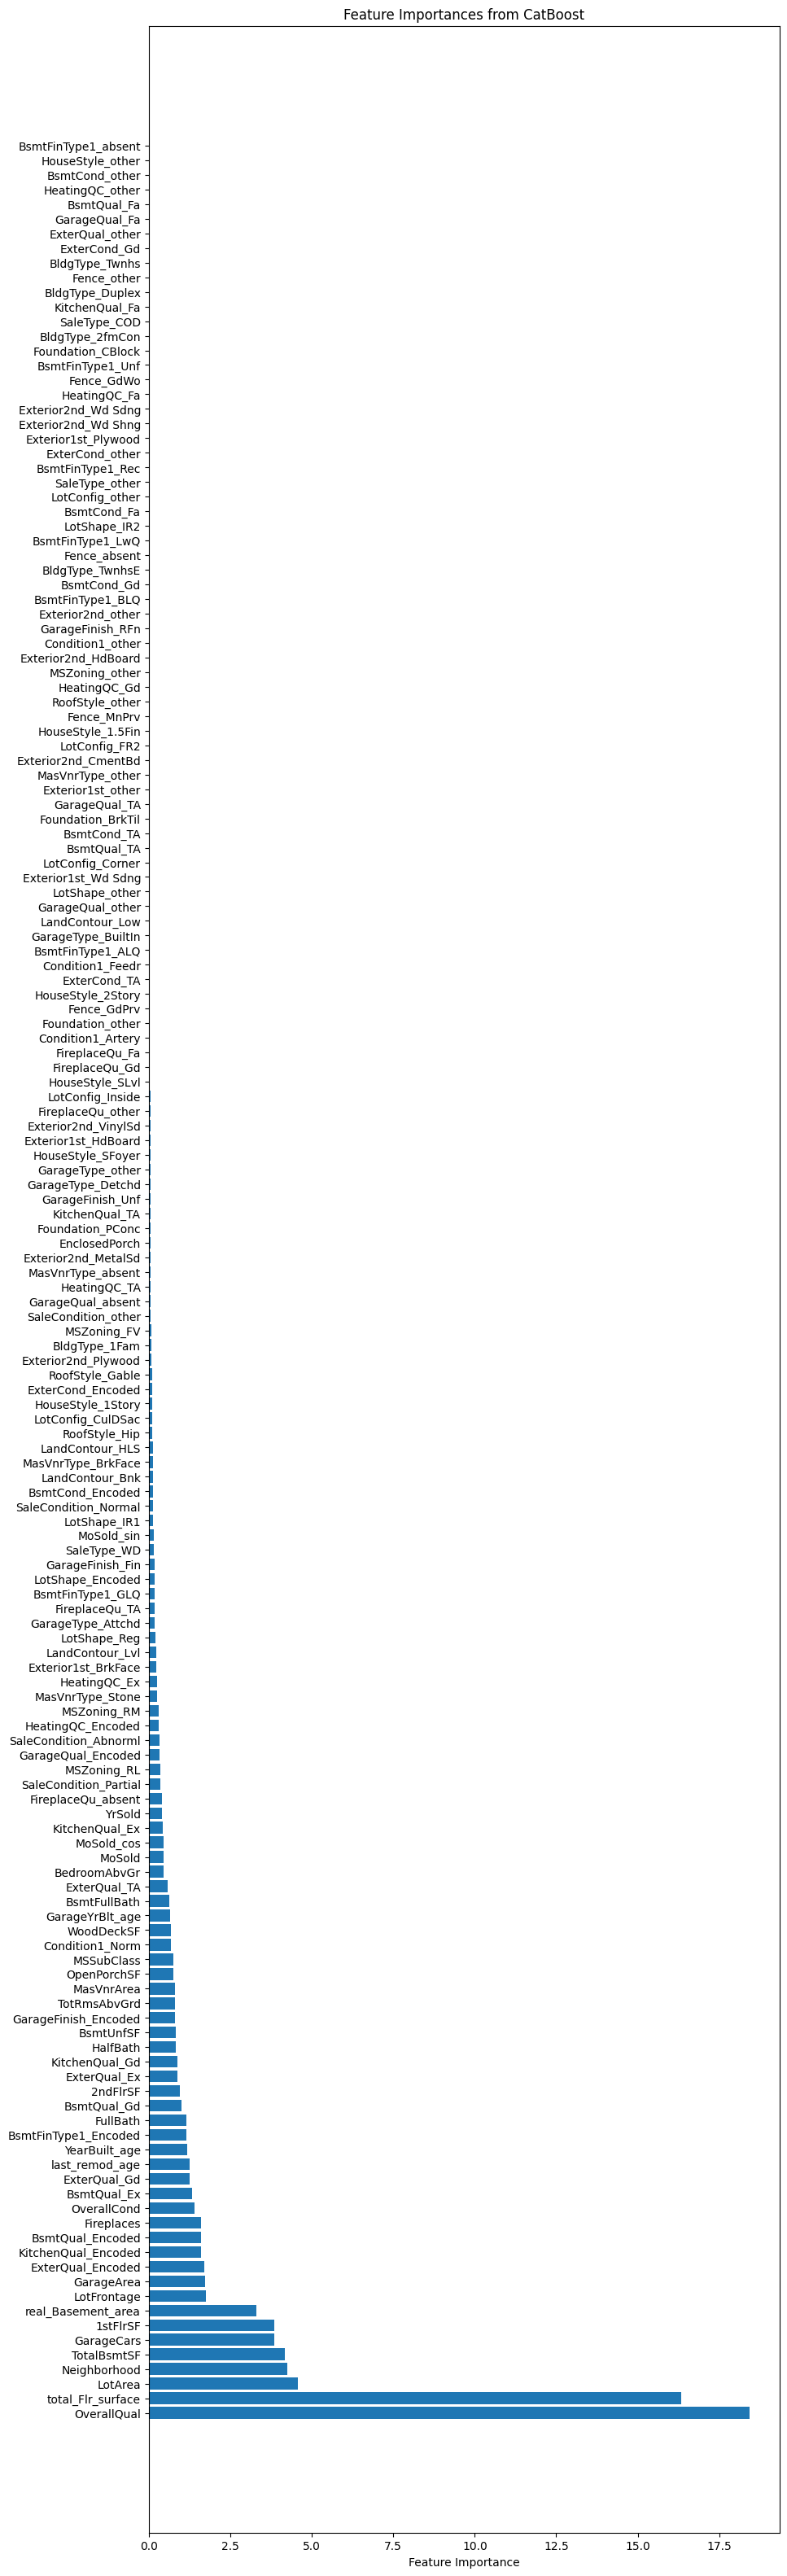

In [122]:
# Plot feature importances
plt.figure(figsize=(10, 40))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Feature Importances from CatBoost")
plt.show()

In [59]:
# Sort by importance and select top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
top_feature_names = top_features['Feature'].values

In [60]:
# Reduce the dataset to the top 10 most important features
X_train_important = X_train[top_feature_names]
X_test_important = X_test[top_feature_names]

### Check with default catoboost

In [61]:
"""min_mae = float('inf')
best_feature_number = None

for feature_number in range(1, len(feature_importance_df)):
    # Sort by importance and select top 10 features
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(feature_number)
    top_feature_names = top_features['Feature'].values

    # Reduce the dataset to the top 10 most important features
    X_train_important = X_train[top_feature_names]
    X_test_important = X_test[top_feature_names]

    # selección del mejor modelo con los mejores parámetros
    modelo_default =  CatBoostRegressor(silent=True, random_state=32)

    # entrenamiento
    modelo_default.fit(X_train_important, y_train)

    # predicción del test
    y_pred = modelo_default.predict(X_test_important)
     # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    print(f'nr of top features: {feature_number}, MAE:, {mae}')

    # Check if current MAE is the minimum
    if mae < min_mae:
        min_mae = mae
        best_feature_number = feature_number

print(f'Best number of top features: {best_feature_number}, Minimum MAE: {min_mae}')"""

"min_mae = float('inf')\nbest_feature_number = None\n\nfor feature_number in range(1, len(feature_importance_df)):\n    # Sort by importance and select top 10 features\n    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(feature_number)\n    top_feature_names = top_features['Feature'].values\n\n    # Reduce the dataset to the top 10 most important features\n    X_train_important = X_train[top_feature_names]\n    X_test_important = X_test[top_feature_names]\n\n    # selección del mejor modelo con los mejores parámetros\n    modelo_default =  CatBoostRegressor(silent=True, random_state=32)\n\n    # entrenamiento\n    modelo_default.fit(X_train_important, y_train)\n\n    # predicción del test\n    y_pred = modelo_default.predict(X_test_important)\n     # Calculate MAE\n    mae = mean_absolute_error(y_test, y_pred)\n\n    print(f'nr of top features: {feature_number}, MAE:, {mae}')\n\n    # Check if current MAE is the minimum\n    if mae < min_mae:\n 

20 features is ok for parameter optimization
99 is the lowest MAE

## hiperparametrizar

In [62]:
# Best parameters for RMSE (replace with your actual values)
best_params_rmse = {
    'bagging_temperature': 0.6492901230430469,
    'border_count': 45,
    'colsample_bylevel': 0.8214516079523371,
    'depth': 4,
    'grow_policy': 'Depthwise',
    'iterations': 434,
    'l2_leaf_reg': 8.243078721770273,
    'learning_rate': 0.08341718788476643,
    'loss_function': 'RMSE',
    'random_strength': 1.1070588579915155,
    'subsample': 0.8733950103313383
}

# Create the CatBoost model with the best parameters
best_model = CatBoostRegressor(**best_params_rmse, verbose=False)

# Fit the model on your training data
best_model.fit(X_train, y_train)  # Replace X_train and y_train with your data

# Make predictions on the test data
y_pred = best_model.predict(X_test)
metrics.mean_absolute_error(y_test, y_pred)

15381.772751698458

In [63]:
#Predict with X_train
test_preds = best_model.predict(predict)

print(test_preds[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission_cat_bestmodel.csv', index=False)

[123623.0, 165274.0, 195103.0, 191690.0, 182290.0, 173884.0, 178712.0, 167174.0, 168222.0, 126381.0, 201302.0, 93297.0, 97056.0, 149109.0, 125468.0]


In [64]:
#Train again with full X and predict

# entrenamiento
best_model.fit(X, y)

# Predict
test_preds = best_model.predict(predict)

print(test_preds[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission_cat_bestmodel_fullX.csv', index=False)

[125134.0, 170196.0, 194801.0, 201267.0, 181025.0, 172104.0, 167389.0, 163762.0, 180320.0, 123838.0, 201554.0, 93881.0, 99893.0, 145821.0, 126430.0]


# DEFAULT MODEL

In [65]:
# selección del mejor modelo con los mejores parámetros
modelo_default =  CatBoostRegressor()

# entrenamiento
modelo_default.fit(X_train, y_train)

# predicción del test
y_pred = modelo_default.predict(X_test)
metrics.mean_absolute_error(y_test, y_pred)

Learning rate set to 0.041084
0:	learn: 75184.1025700	total: 8.61ms	remaining: 8.61s
1:	learn: 73538.5201406	total: 15.7ms	remaining: 7.83s
2:	learn: 71910.8688538	total: 20.8ms	remaining: 6.9s
3:	learn: 70249.0481078	total: 27ms	remaining: 6.73s
4:	learn: 68490.8550641	total: 33.3ms	remaining: 6.63s
5:	learn: 66878.5818130	total: 39.8ms	remaining: 6.6s
6:	learn: 65300.2114456	total: 45.2ms	remaining: 6.41s
7:	learn: 63790.9749606	total: 49.8ms	remaining: 6.17s
8:	learn: 62269.4543662	total: 55.5ms	remaining: 6.11s
9:	learn: 60787.7495658	total: 60.4ms	remaining: 5.98s
10:	learn: 59476.2282286	total: 65.5ms	remaining: 5.89s
11:	learn: 58317.6290377	total: 71.5ms	remaining: 5.89s
12:	learn: 57035.8165738	total: 76.8ms	remaining: 5.83s
13:	learn: 55920.5099076	total: 81.8ms	remaining: 5.76s
14:	learn: 54693.0087233	total: 88.2ms	remaining: 5.79s
15:	learn: 53549.2282181	total: 93.1ms	remaining: 5.73s
16:	learn: 52440.0062883	total: 98.2ms	remaining: 5.68s
17:	learn: 51408.4223681	total: 

15103.4951346975

In [66]:
#Predict with X_train
test_preds = modelo_default.predict(predict)

print(test_preds[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission_cat_default.csv', index=False)

[119995.0, 158908.0, 188692.0, 193706.0, 176776.0, 173448.0, 172820.0, 164799.0, 175492.0, 125198.0, 195211.0, 99081.0, 97701.0, 145974.0, 127975.0]


In [67]:
#Train again with full X and predict
# selección del mejor modelo con los mejores parámetros
modelo_default =  CatBoostRegressor()

# entrenamiento
modelo_default.fit(X, y)

# Predict
test_preds = modelo_default.predict(predict)

print(test_preds[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission_cat_default_fullX.csv', index=False)

Learning rate set to 0.043466
0:	learn: 77210.8650489	total: 23.2ms	remaining: 23.2s
1:	learn: 75401.7211845	total: 32.2ms	remaining: 16.1s
2:	learn: 73471.0477065	total: 46.3ms	remaining: 15.4s
3:	learn: 71581.2015175	total: 52.7ms	remaining: 13.1s
4:	learn: 69596.6558518	total: 58.5ms	remaining: 11.6s
5:	learn: 67697.2852855	total: 65.2ms	remaining: 10.8s
6:	learn: 65924.7496129	total: 72.3ms	remaining: 10.3s
7:	learn: 64102.9961180	total: 77.7ms	remaining: 9.64s
8:	learn: 62485.5788345	total: 82.9ms	remaining: 9.12s
9:	learn: 60992.1619068	total: 88.8ms	remaining: 8.79s
10:	learn: 59557.8201310	total: 94.1ms	remaining: 8.46s
11:	learn: 58199.3566616	total: 101ms	remaining: 8.28s
12:	learn: 56842.3588924	total: 106ms	remaining: 8.08s
13:	learn: 55549.4252921	total: 112ms	remaining: 7.86s
14:	learn: 54251.8460444	total: 119ms	remaining: 7.79s
15:	learn: 52924.1392741	total: 124ms	remaining: 7.62s
16:	learn: 51746.0869903	total: 129ms	remaining: 7.44s
17:	learn: 50724.1987005	total: 13

# Default model 99 top features

In [68]:
# Sort by importance and select top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(99)
top_feature_names = top_features['Feature'].values

# Reduce the dataset to the top 10 most important features
X_train_important = X_train[top_feature_names]
X_test_important = X_test[top_feature_names]

# selección del mejor modelo con los mejores parámetros
modelo_default =  CatBoostRegressor(silent=True)

# entrenamiento
modelo_default.fit(X_train_important, y_train)

# predicción del test
y_pred = modelo_default.predict(X_test_important)
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(mae)

15001.914078302158


In [69]:
#Predict with X_train
test_preds = modelo_default.predict(predict)

print(test_preds[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission_cat_default_99.csv', index=False)

[120904.0, 159123.0, 185783.0, 190962.0, 183336.0, 170948.0, 181022.0, 167045.0, 175751.0, 127497.0, 198015.0, 95571.0, 92466.0, 144247.0, 126624.0]


In [70]:
#Train again with full X and predict
# selección del mejor modelo con los mejores parámetros
modelo_default =  CatBoostRegressor()

# Reduce the dataset to the top 10 most important features
X_important = X[top_feature_names]
predict_important = predict[top_feature_names]

# entrenamiento
modelo_default.fit(X, y)

# Predict
test_preds = modelo_default.predict(predict_important)

print(test_preds[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission_cat_default_fullX_99.csv', index=False)

Learning rate set to 0.043466
0:	learn: 77210.8650489	total: 6.26ms	remaining: 6.26s
1:	learn: 75401.7211845	total: 12ms	remaining: 5.99s
2:	learn: 73471.0477065	total: 17ms	remaining: 5.65s
3:	learn: 71581.2015175	total: 22.2ms	remaining: 5.52s
4:	learn: 69596.6558518	total: 27.5ms	remaining: 5.47s
5:	learn: 67697.2852855	total: 33.1ms	remaining: 5.49s
6:	learn: 65924.7496129	total: 37.3ms	remaining: 5.29s
7:	learn: 64102.9961180	total: 42.4ms	remaining: 5.25s
8:	learn: 62485.5788345	total: 47ms	remaining: 5.17s
9:	learn: 60992.1619068	total: 51.2ms	remaining: 5.06s
10:	learn: 59557.8201310	total: 58.4ms	remaining: 5.25s
11:	learn: 58199.3566616	total: 63.1ms	remaining: 5.2s
12:	learn: 56842.3588924	total: 67.8ms	remaining: 5.15s
13:	learn: 55549.4252921	total: 73.1ms	remaining: 5.15s
14:	learn: 54251.8460444	total: 78.4ms	remaining: 5.14s
15:	learn: 52924.1392741	total: 82.5ms	remaining: 5.08s
16:	learn: 51746.0869903	total: 88.2ms	remaining: 5.1s
17:	learn: 50724.1987005	total: 93.2

# Final results XGBoost

### MAE = 14163.46
### Rank in public leaderboard = 1487/97455

# Final results CatBoost

### MAE = 13788
### Rank in public leaderboard = 980/97455